In [ ]:
## 1. Setup
#import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import AffinityPropagation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Описательная статистика

---



In [ ]:
codes = pd.read_csv('/content/drive/MyDrive/datasets/CodesForCourse.csv')
codes.head()

,dept_code,issue_date,issuer,issuer_eng,values
0,20003,2001-11-05,ОУФМС,OUFMS,20003_345
1,20003,2002-03-22,МВД ПО РЕСПУБЛИКЕ БАШКОРТОСТАН,MVD PO RESPUBLIKE BASHKORTOSTAN,20003_319
2,20003,2002-05-18,МВД ПО РЕСПУБЛИКЕ БАШКОРТОСТАН,MVD PO RESPUBLIKE BASHKORTOSTAN,20003_319
3,20003,2002-08-13,ОТДЕЛОМ УФМС РОССИИ ПО РЕСПУБЛИКЕ БАШКОРТОСТАН...,OTDELOM UFMS ROSSII PO RESPUBLIKE BASHKORTOSTA...,20003_346
4,20003,2003-07-17,ОТДЕЛОМ УФМС РОССИИ ПО РЕСПУБЛИКЕ БАШКОРТОСТАН...,OTDELOM UFMS ROSSII PO RESPUBLIKE BASHKORTOSTA...,20003_347


Each id has a unique number, the issue date, a code that represents where the id was issued (dept_code in the data) and the description of the place where the id was issued (issue_eng). 

In [ ]:
codes.tail()

,dept_code,issue_date,issuer,issuer_eng,values
104406,860004,2019-11-22,УМВД РОССИИ ПО ХАНТЫ-МАНСИЙСКОМУ АВТОНОМНОМУ О...,UMVD ROSSII PO HANTY-MANSIJSKOMU AVTONOMNOMU O...,860004_42927
104407,860004,2019-11-22,УМВД РОССИИ ПО ХАНТЫ-МАНСИЙСКОМУ АВТОНОМНОМУ О...,UMVD ROSSII PO HANTY-MANSIJSKOMU AVTONOMNOMU O...,860004_42927
104408,860004,2019-12-10,УМВД РОССИИ ПО ХАНТЫ-МАНСИЙСКОМУ АВТОНОМНОМУ О...,UMVD ROSSII PO HANTY-MANSIJSKOMU AVTONOMNOMU O...,860004_111661
104409,860004,2019-12-16,УМВД РОССИИ ПО ХАНТЫ-МАНСИЙСКОМУ АВТОНОМНОМУ О...,UMVD ROSSII PO HANTY-MANSIJSKOMU AVTONOMNOMU O...,860004_42927
104410,860004,2020-01-11,УМВД РОССИИ ПО ХАНТЫ-МАНСИЙСКОМУ АВТОНОМНОМУ О...,UMVD ROSSII PO HANTY-MANSIJSKOMU AVTONOMNOMU O...,860004_42927


In [ ]:
dept_codes_counted = codes.groupby("dept_code").count()
dept_codes_counted = dept_codes_counted[['values']]
dept_codes_counted.describe()

,values
count,42.000000
mean,2485.976190
std,545.645355
min,2011.000000
25%,2154.000000
50%,2317.000000
75%,2582.500000
max,4804.000000


In [ ]:
codes.count()

dept_code     104411
issue_date    104411
issuer        104411
issuer_eng    104411
values        104411
dtype: int64

всего наблюдений в таблице 104411, без пропущенных значений

уникальных кодов - 42, на каждый код существует от 2011 до 4804 наблюдений

In [ ]:
issuer_counted = codes.groupby(by=["dept_code", "issuer"]).count()
issuer_counted = issuer_counted[['values']]
issuer_counted.head()
issuer_counted.describe()

,values
count,4520.000000
mean,23.099779
std,150.681751
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2821.000000


На русском всего различных вариантов текста 4520. на каждый вариант текста приходится от 1 до 2821 наблюдений со средним значением в 23. Причем половина текстовых вариантов встречается только по одному разу, значит, в них высока вероятность опечаток или редкоиспользуемых сокращений  

На английском всего 4514 текстов, остальное, как на русском.

In [ ]:
issuer_eng_counted = codes.groupby(by=["dept_code", "issuer_eng"]).count()
issuer_eng_counted = issuer_eng_counted[['values']]
issuer_eng_counted.describe()

,values
count,4514.000000
mean,23.130483
std,150.797906
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2821.000000


In [ ]:
codes['issue_date'] = pd.to_datetime(codes['issue_date'])
#codes['month&year'] = codes['issue_date'].dt.to_period('M')
#codes['month&year']

In [ ]:
text_length = [len(i) for i in codes['issuer_eng']]
text_length = pd.DataFrame(text_length, columns=['text'])
text_length = text_length.join(codes[["issuer_eng"]])
text_length.describe()

,text
count,104411.000000
mean,65.164082
std,14.729673
min,3.000000
25%,58.000000
50%,67.000000
75%,76.000000
max,133.000000


In [ ]:
text_length.loc[text_length.text <= 3]

,text,issuer_eng
10042,3,UVD
34173,3,UVD
41403,3,UVD


**Среднее количество символов в строке issuer_eng  - 65, медиана - 67**


Модель 1

---



In [ ]:
y = codes.issuer_eng
X = codes[['dept_code', 'issue_date']]


In [ ]:
# Разделим данные на тренировочную и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/5, random_state = 4)
y_train.head()

88701    OTDELOM UFMS ROSSII PO SARATOVSKOJ OBLASTI V G...
55283    OUFMS ROSSII PO IRKUTSKOJ OBLASTI V GOR BRATSK...
43414    OTDELOM UFMS ROSSII PO VOLOGODSKOJ OBLASTI V G...
40860    OTDELOM UFMS ROSSII PO VOLGOGRADSKOJ OBLASTI V...
717      OTDELOM UFMS ROSSII PO RESPUBLIKE BASHKORTOSTA...
Name: issuer_eng, dtype: object

In [ ]:
def nearest(items, pivot): return min(items, key=lambda x: abs(x - pivot)) 

def autosuggestion_model(x_train, Y_train, x_test):
  d_codes = []
  i_dates = []
  ids = []
  texts = []

  for i in range(len(x_test)):
    d_code = int(x_test.dept_code.iloc[[i]])
    d_codes.append(d_code)
    i_date = x_test.issue_date.iloc[[i]].dt.date
    i_dates.append(i_date.iloc[0])
    df1 = x_train.loc[x_train.dept_code==d_code]
    df2 = df1.loc[df1.issue_date.dt.date==nearest(df1.issue_date.dt.date, i_date.iloc[0])]
    id = df2.index[0]
    ids.append(id)
    text = Y_train.loc[[id]]
    texts.append(text.iloc[0])
  
  pred = {'dept_code': d_codes, 'issue_date': i_dates, 'issue_eng_pred': texts}
  prediction = pd.DataFrame(pred, index=range(len(x_test)))
  return prediction

#autosuggestion_model(X_train, y_train, X_test)


In [ ]:
prediction = autosuggestion_model(X_train, y_train, X_test)

In [ ]:
prediction.to_excel('prediction1.xlsx')

Оценка точности модели

---



In [ ]:
%pip install /content/drive/MyDrive/datasets/python-Levenshtein-0.12.0.tar.gz

Processing ./drive/MyDrive/datasets/python-Levenshtein-0.12.0.tar.gz
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.0-cp36-cp36m-linux_x86_64.whl size=144791 sha256=255db90c19248f80c87a12dabbab7a1188da1b09e37354eb7c3d93006b1e8fcf
  Stored in directory: /root/.cache/pip/wheels/fb/fc/18/2f8bfa7228d365b02baa14c06a2c9ea5d5677b1f2a20528eff
Successfully built python-Levenshtein
  Found existing installation: python-Levenshtein 0.12.0
    Uninstalling python-Levenshtein-0.12.0:
      Successfully uninstalled python-Levenshtein-0.12.0


In [ ]:
import Levenshtein as lev

In [ ]:
s1 = prediction.issue_eng_pred.head()
s2 = y_test.head()
print(s1.iloc[3],'\\', s2.iloc[3])

OTDELOM UFMS ROSSII PO IRKUTSKOJ OBLASTI V GOR. ANGARSKE I ANGARSKOM R-NE \ OTDEL UFMS ROSSII PO IRKUTSKOJ OBL. V G. ANGARSKE I ANGARSKOM R-NE


In [ ]:
lev_distance = []
for i in range(len(y_test)):
  lev_distance.append(lev.distance(prediction.issue_eng_pred.iloc[i], y_test.iloc[i])) 
  

(array([1.9259e+04, 7.3500e+02, 2.6000e+02, 9.0000e+01, 9.4000e+01,
        9.5000e+01, 8.9000e+01, 5.0000e+01, 5.4000e+01, 4.3000e+01,
        3.9000e+01, 2.7000e+01, 1.6000e+01, 8.0000e+00, 1.2000e+01,
        5.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00, 3.0000e+00]),
 array([ 0. ,  4.1,  8.2, 12.3, 16.4, 20.5, 24.6, 28.7, 32.8, 36.9, 41. ,
        45.1, 49.2, 53.3, 57.4, 61.5, 65.6, 69.7, 73.8, 77.9, 82. ]),
 <a list of 20 Patch objects>)

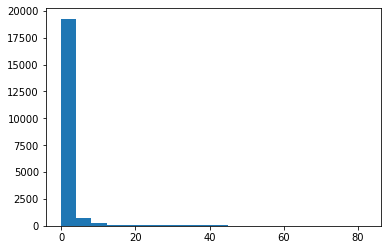

In [ ]:
plt.hist(lev_distance, bins=20)

In [ ]:
max(lev_distance)

82

In [ ]:
min(lev_distance)

0

In [ ]:
proportion = []
for i in range(84):
  sum_of_entries = 0
  for num in lev_distance:
    if num < i:
      sum_of_entries += 1
    else:
      continue
  share = sum_of_entries / len(lev_distance)
  proportion.append(share)

#print(proportion)

In [ ]:
import matplotlib.ticker as ticker

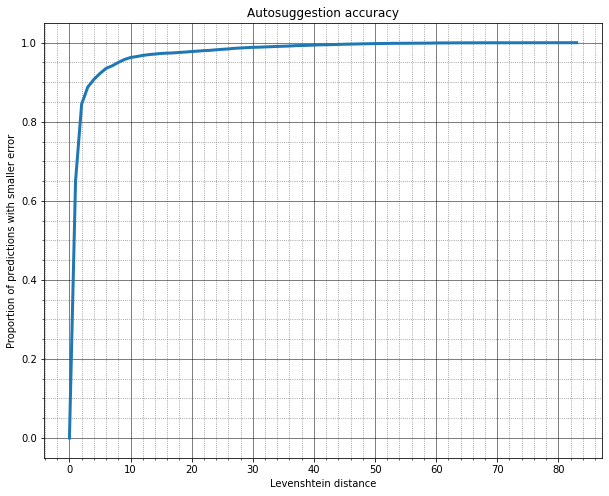

In [ ]:
ld = list(range(84))
fig, ax = plt.subplots(figsize=[10, 8])
ax.plot(ld, proportion, linewidth=3)
plt.title("Autosuggestion accuracy")
plt.xlabel("Levenshtein distance")
plt.ylabel("Proportion of predictions with smaller error")
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax.grid(which='major',
        color = 'k', linewidth=0.5)
ax.minorticks_on()
ax.grid(which='minor',
        color = 'gray',
        linestyle = ':')
plt.show()

Таким образом, размер ошибок предсказаний данной модели составляет менее 8 символов для 95% предсказаний или менее 2 символов для 85%.

Кластеринг


---



In [ ]:
y_tr = np.array(y_train)
X_train[["issuer_eng"]] = y_tr

In [ ]:
issuer_eng_counted = X_train.groupby(by=["dept_code", "issuer_eng"]).count()
issuer_eng_counted.head() 

issue_date
dept_code issuer_eng                                                    
20003     KALININSKIM RUVD G. UFY RESPUBLIKI BASHKORTOSTAN             1
          KALININSKIM RUVD GOR.UFY RESPUBLIKIBASHKORTOSTAN             1
          MVD PO RB                                                    1
          MVD PO RESPUBLIKE BASHKORTOSTAN                            141
          ORDZHONIKIDZEVSKIM RUVD GOR. UFY RESPUBLIKI BAS...           1

In [ ]:
issuer_eng_unique = issuer_eng_counted
#
# issuer_eng_counted.reset_index()
#tx = t.issuer_eng
txt = []
#
for i in range(len(issuer_eng_unique)):
  t =issuer_eng_unique.index[i][1]
  txt.append(t)

txt = np.array(txt)
issuer_eng_unique['texts'] = txt
issuer_eng_unique = issuer_eng_unique.drop('issue_date',  axis=1)
issuer_eng_unique.head()

texts
dept_code issuer_eng                                                                                           
20003     KALININSKIM RUVD G. UFY RESPUBLIKI BASHKORTOSTAN     KALININSKIM RUVD G. UFY RESPUBLIKI BASHKORTOSTAN
          KALININSKIM RUVD GOR.UFY RESPUBLIKIBASHKORTOSTAN     KALININSKIM RUVD GOR.UFY RESPUBLIKIBASHKORTOSTAN
          MVD PO RB                                                                                   MVD PO RB
          MVD PO RESPUBLIKE BASHKORTOSTAN                                       MVD PO RESPUBLIKE BASHKORTOSTAN
          ORDZHONIKIDZEVSKIM RUVD GOR. UFY RESPUBLIKI BAS...  ORDZHONIKIDZEVSKIM RUVD GOR. UFY RESPUBLIKI BA...

In [ ]:
issuer_eng_unique.filter(like=str(code), axis=0).iloc[1][0]

texts
dept_code issuer_eng                                                                                           
630005    OTDELOM UFMS ROSSII PO KRASNOJARSKOMU KRAJU I R...  OTDELOM UFMS ROSSII PO KRASNOJARSKOMU KRAJU I ...
          OUFMS V GOR. NORIL'SKE                                                         OUFMS V GOR. NORIL'SKE
          UPRAVLENIEM VNUTRENNIH DEL ZASVIJAZHSKOGO RAJON...  UPRAVLENIEM VNUTRENNIH DEL ZASVIJAZHSKOGO RAJO...
          UPRAVLENIEM VNUTRENNIH DEL ZASVIJAZHSKOGO RAJON...  UPRAVLENIEM VNUTRENNIH DEL ZASVIJAZHSKOGO RAJO...

In [ ]:
d_codes_list = X_train.dept_code
d_codes_list = d_codes_list.unique()
d_codes_list = list(d_codes_list)
clustered_texts = []
coddes = []
unq_tx = []

for code in d_codes_list:
  unique_texts = issuer_eng_unique.filter(like=str(code), axis=0)
  df_lev_dist = np.matrix(range(len(unique_texts)))
  df_lev_dist = pd.DataFrame(df_lev_dist)
  df_lev_dist = df_lev_dist.drop(labels = 0)  
  
  for i in range(len(unique_texts)):
    row_lev_dist =np.empty(shape=[0, len(unique_texts)])
    unq_tx.append(unique_texts.iloc[i][0])
    for j in range(len(unique_texts)):
      lev_dist = lev.distance(str(unique_texts.iloc[i][0]), str(unique_texts.iloc[j][0]))    
      lev_dist = int(-1*lev_dist)
      row_lev_dist = np.append(row_lev_dist, lev_dist)
  
    row_lev_dist = pd.Series(row_lev_dist)
    df_lev_dist = df_lev_dist.append(row_lev_dist, ignore_index=True)

  af = AffinityPropagation(max_iter=500, affinity='precomputed', convergence_iter=5).fit(df_lev_dist) 
  cluster_centers_indices = af.cluster_centers_indices_

  for label in af.labels_:
    index = cluster_centers_indices[label]
    clustered_texts.append(str(unique_texts.iloc[index][0]))
    coddes.append(code)
  



#print(len(clustered_texts)) 

In [ ]:
len(unq_tx)

3817

In [ ]:
clu_tx = np.array(clustered_texts)
codees = np.array(coddes)
unq_tx = np.array(unq_tx)
df_exemplars = pd.DataFrame(clu_tx, codees, columns=['cleaned_text'])
df_exemplars[['issuer_eng']] = unq_tx
df_exemplars.head()

,cleaned_text,issuer_eng
640044,GU MVD ROSSII PO SARATOVSKOJ OBLASTI,GU MVD PO SARATOVSKOJ OBLASTI
640044,GU MVD ROSSII PO SARATOVSKOJ OBLASTI,GU MVD ROSSII PO SARATOVSKOJ OBLASTI
640044,GU MVD ROSSII PO SARATOVSKOJ OBLASTI,"GU MVD ROSSII PO SARATOVSKOJ OBLASTI,"
640044,GU MVD ROSSII PO SARATOVSKOJ OBLASTI,GU MVD ROSSII PO SARATOVSKOJ OBLASTNOJ
640044,OTDELOM UFMS ROSSII PO SARATOVSKOJ OBLASTI V G...,ODELOM UFMS ROSSII PO SARATOVSKOJ OBLASTI V GO...


In [ ]:
cl_tx = []
c = X_train[['dept_code', 'issuer_eng']]
for i in range(len(c)):
  cod = c.dept_code.iloc[i]
  txx = c.issuer_eng.iloc[i]
  tx = df_exemplars.filter(like=str(cod), axis=0)
  tx = tx.loc[tx.issuer_eng == txx] 
  cl_tx.append(tx.cleaned_text.item())


In [ ]:
cl_txt = np.array(cl_tx)
X_train[['clustered_issuer']] = cl_txt
X_train.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:659: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[k] = np.nan
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

,dept_code,issue_date,issuer_eng,clustered_issuer
88701,640044,2013-07-12,OTDELOM UFMS ROSSII PO SARATOVSKOJ OBLASTI V G...,OTDELOM UFMS ROSSII PO SARATOVSKOJ OBLASTI V G...
55283,380010,2008-01-12,OUFMS ROSSII PO IRKUTSKOJ OBLASTI V GOR BRATSK...,OUFMS ROSSII PO IRKUTSKOJ OBLASTI V GOR BRATSK...
43414,350002,2017-09-11,OTDELOM UFMS ROSSII PO VOLOGODSKOJ OBLASTI V G...,OTDELOM UFMS ROSSII PO VOLOGODSKOJ OBLASTI V G...
40860,340011,2015-12-06,OTDELOM UFMS ROSSII PO VOLGOGRADSKOJ OBLASTI V...,OTDELOM UFMS ROSSII PO VOLGOGRADSKOJ OBLASTI V...
717,20003,2010-11-11,OTDELOM UFMS ROSSII PO RESPUBLIKE BASHKORTOSTA...,OTDELOM UFMS ROSSII PO RESPUBLIKE BASHKORTOSTA...


Модель 2


---



In [ ]:
y_train = X_train.clustered_issuer
X_train = X_train[['dept_code', 'issue_date']]

In [ ]:
prediction = autosuggestion_model(X_train, y_train, X_test)

In [ ]:
lev_distance = []
for i in range(len(y_test)):
  lev_distance.append(lev.distance(prediction.issue_eng_pred.iloc[i], y_test.iloc[i])) 
  

In [ ]:
proportion = []
for i in range(84):
  sum_of_entries = 0
  for num in lev_distance:
    if num < i:
      sum_of_entries += 1
    else:
      continue
  share = sum_of_entries / len(lev_distance)
  proportion.append(share)

#print(proportion)

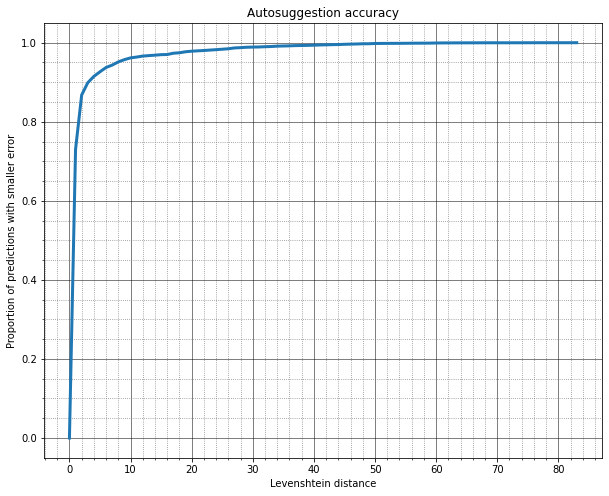

In [ ]:
ld = list(range(84))
fig, ax = plt.subplots(figsize=[10, 8])
ax.plot(ld, proportion, linewidth=3)
plt.title("Autosuggestion accuracy")
plt.xlabel("Levenshtein distance")
plt.ylabel("Proportion of predictions with smaller error")
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax.grid(which='major',
        color = 'k', linewidth=0.5)
ax.minorticks_on()
ax.grid(which='minor',
        color = 'gray',
        linestyle = ':')
plt.show()

Таким образом, размер ошибок предсказаний данной модели сократился до  менее 2 символов для 95% предсказаний.